# Credit Card Fraud Detection

<a id="contents"></a>
### Contents
#### 1. [Introduction](#intro)<br></br>
#### 2. [Data Preprocessing](#preprocessing)<br></br>
#### 3. [Training](#training)<br></br>
#### 4. [Handling the Imbalance](#imbalance)<br></br>
#### 5. [Model Evaluation](#evaluation)<br></br>
#### 6. [Conclusions](#conclusions)<br></br>
#### 7. [Recommendations](#recommends)<br></br>


<a id="intro"></a>
## Introduction

Credit card fraud is the unauthorized use of a credit or debit card or a similar payment tool, to fraudulently obtain money or property.
In 2018, money lost from fraud involving credit cards worldwide reached $27.85 billion.
It is important that credit card companies are able to detect and decline fraudulent credit card transactions so that their customers are not wrongly charged.
This aim of this project is to create a model to detect such fraudulent transactions using data from previous transactions, gotten from [Credit Card Fraud Detection | Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).

## Dataset Description

The Dataset contains transactions made in September 2013 by European cardholders.
It presents transactions that occurred in two days. It contains 284,807 instances, each representing a transaction. It contains 30 features. Features V1, V2, ... , V28 are the principal components obtained with PCA; the only features which have not been transformed with PCA are 'Time' and 'Amount'. It contains only numerical input variables which are the result of a PCA transformation. 

| Column | Type | Description |
| --- | :---: |:--- |
| Time | continuous | seconds elapsed between each transaction and the first transaction in the dataset |
| V1 | continuous | principal components obtained with PCA |
| V2 | continuous | principal components obtained with PCA |
| V3 | continuous | principal components obtained with PCA |
| V4 | continuous | principal components obtained with PCA |
| ... | ... | ... |
| V26 | continuous | principal components obtained with PCA |
| V27 | continuous | principal components obtained with PCA |
| V28 | continuous | principal components obtained with PCA |
| Amount | continuous | transaction amount |
| Class | continuous | response variable, 1 for fraud and 0 otherwise |


In [1]:
import numpy as np
import pandas as pd
import gzip
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score, plot_confusion_matrix
import pickle

In [2]:
sns.set()

In [3]:
def read_csv(fn):
    with gzip.open(fn, "rt", newline='', encoding="UTF-8") as file:
        return pd.read_csv(file)

DATA_CACHE = None

def get_data():
    global DATA_CACHE
    if DATA_CACHE is None:
        DATA_CACHE = read_csv('creditcard.csv.gz')
    return DATA_CACHE

In [4]:
data = get_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

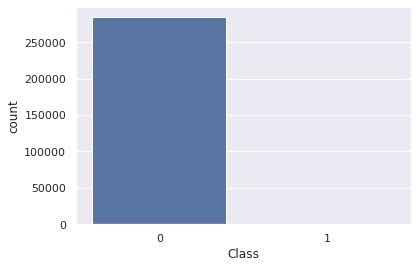

In [7]:
sns.countplot(x = data.Class)

This shows an imbalanced dataset, with only 492 instances classified as fraud, out of 284,807.

In [8]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
traindata, evaldata = train_test_split(data, test_size = 0.5, random_state = 97)
print("Traindata shape: {}\nEvaldata shape: {}".format(traindata.shape, evaldata.shape))

Traindata shape: (142403, 31)
Evaldata shape: (142404, 31)


In [10]:
print("Traindata:\n{}\n\nEvaldata:\n{}".format(traindata.Class.value_counts(), evaldata.Class.value_counts()))

Traindata:
0    142145
1       258
Name: Class, dtype: int64

Evaldata:
0    142170
1       234
Name: Class, dtype: int64


<a id="preprocessing"></a>
## Preprocessing

Helper Functons to help with training. <br>
[Back to Contents](#contents)

In [11]:
#Some helper fuctions, for training, testing and evaluating.
def evalscore(actual, predictions):
    """
    Calculates the following Metrics: precision score, recall_score and f1 score.
    
    args:
        actual: the actual values of the label.
        predictions: the predictions made by the model.
        
    returns: a list of the metric scores [precision score, 'recall_score', 'f1_score']  
    """
    temp = [precision_score(actual, predictions), recall_score(actual, predictions), f1_score(actual, predictions)]
    return temp


def compareModels(models, xtrain, ytrain, xtest, ytest):
    """
    Trains each model in models using xtrain and ytrain and evaluates on xtest and ytest.
    It creates a dataframe showing the comparison.
    
    args:
        models: a list of models to compare.
        xtrain, ytrain: the features and labels for training.
        xtest, ytest: the features and labels for evaluation.
    
    returns: tuple[trained_models, dataframe]
            trained_models: a list of the trained models, dataframe: a dataframe showing the comparisons
    """
    trained = {}
    dt = {}
    for model in models:
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        dt[models[model]] = evalscore(ytest, preds)
        trained[model] = models[model]
    return trained, pd.DataFrame(dt, index = ['precision score', 'recall_score', 'f1_score'])

    
def compareModelsCV(models, x, y):
    """
    Trains each model in models using and the models are validated using KFold cross validation.
    It creates a dataframe showing the comparison.
    
    args:
        models: a list of models to compare.
        xtrain, ytrain: the features and labels for training.
        xtest, ytest: the features and labels for evaluation.
    
    returns: tuple[trained_models, dataframe]
            trained_models: a list of the trained models, dataframe: a dataframe showing the comparisons
    """
    trained = {}
    dt = {}
    kf = KFold(n_splits = 5, shuffle = True)
    for model in models:
        scores = []
        for tr, te in kf.split(x):
            xtrain, xtest, ytrain, ytest = x[tr], x[te], y[tr], y[te]
            model.fit(xtrain, ytrain)
            preds = model.predict(xtest)
            scores.append(evalscore(ytest, preds))       
        dt[models[model]] = np.array(scores).mean(axis = 0)
        trained[model] = models[model]
    return trained, pd.DataFrame(dt, index = ['precision score', 'recall_score', 'f1_score'])

def evalModels(models, x, actual):
    """Testing function"""
    dt = {}
    for model in models:
        preds = model.predict(x)
        dt[models[model]] = evalscore(actual, preds)
    return pd.DataFrame(dt, index = ['precision score', 'recall_score', 'f1_score'])

In [12]:
X, y = traindata.drop('Class', axis = 1), traindata.Class


We scaled the entire dataset to reduce bias/variance.

In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data = pd.DataFrame(scaled_data, columns = X.columns)
fx, fy = scaled_data, y

<a id="training"></a>
## Training
[Back to Contents](#contents)

The data was trained with five different models; Support Vector Machine, Naive Bayes, Logistic Regression, Decision Trees and Random Forest.

In [14]:
svm = SVC(probability = True)
rf = RandomForestClassifier(class_weight = {0: 1, 1: 0.02})
models = {svm: 'SVM', rf: "Random Forest"}

Training a base model without any tuning and using all the features.

#### Cross Validation

In [ ]:
#trained_models, summary = compareModelsCV(models, scaled_data.values, y.values)
#summary

In [21]:
with open('pickles/supportvector', 'rb') as f:
    svm = pickle.load(f)
     

In [22]:
m1 = {svm: 'SVM'}
           
           

<a id="imbalance"></a>
## Handling the imbalance
Oversampling and undersampling techniques are applied to reduce imbalance.<br>
[Back to Contents](#contents)

In [ ]:
overs = SMOTE(sampling_strategy = 0.1)
unders = RandomUnderSampler(sampling_strategy = 0.1)
steps = [("over", overs), ("under", unders)]
pipe = Pipeline(steps = steps)
X, y = pipe.fit_resample(X, y)

In [ ]:
scaler = StandardScaler()
hiscaled_data = scaler.fit_transform(X)
hiscaled_data = pd.DataFrame(hiscaled_data, columns = X.columns)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(hiscaled_data, y, test_size = 0.33, random_state = 43,) # stratify = y)
print("Train shapes:\nxtrain: {}\nytrain: {}\n\nTest shapes\nxtest: {}\nytest: {}".format(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape))

In [ ]:
ytest.value_counts()

In [ ]:
#trained_models, summary = compareModelsCV(models, xtrain, ytrain, xtest, ytest)
#summary

In [28]:
with open('pickles/supportvector_imb', 'rb') as f:
    svm_imb = pickle.load(f)
    
m2 = {svm_imb: 'SVM'}

/data/user/0/ru.iiec.pydroid3/files/arm-linux-androideabi/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


#### Training with full traindata

In [ ]:
#final_model = { , }
final_model.fit(fx, fy)

<a id="evaluation"></a>
## Model Evaluation
The evaluation metric chosen was the precision score. This was chosen bcause we want our model to predict the positive cases as correctly as possible. <br>
[Back to Contents](#contents)

In [25]:
scaled_test = scaler.fit_transform(evaldata.drop("Class", axis = 1))
scaled_test = pd.DataFrame(scaled_test, columns = evaldata.drop("Class", axis= 1).columns)

In [26]:
y_test = evaldata.Class
y_test.value_counts()

0    142170
1       234
Name: Class, dtype: int64

In [ ]:
final_model_dict = m2
evalModels(final_model_dict, scaled_test, y_test)

<a id="conclusions"></a>
## Conclusions
The final model has a precision score of  .

<a id="recommends"></a>
## Recommendations
    1. Get more data for the positive cases.
    2. Use GridSearchCV or RandomizedSearchCV to search for the best hyperparameters.
    3. Use more advanced algorithms like xgboost, lightgbm, etc
     
[Back to top](#contents)